# NLP Transformer for Multi-Label Film Genre Classification

In [38]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#### The Movies Dataset

This notebook makes use of the [Kaggle Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). 

In [2]:
movies_metadata = pd.read_csv(os.path.join('data', 'movies_metadata.csv'))
movies_metadata.shape

(45466, 24)

In [3]:
movies_metadata.sample(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
42588,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,109398,tt0376293,de,Unsere Afrikareise,Kubelka was asked to do a documentation group ...,...,1966-01-01,0.0,13.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Our Trip to Africa,False,6.9,12.0
32327,False,"{'id': 253537, 'name': 'Spud Collection', 'pos...",0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,200580,tt2262270,en,Spud 2: The Madness Continues,"The year is 1991, and Spud Milton's long walk ...",...,2013-06-06,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Spud 2: The Madness Continues,False,7.2,9.0
21913,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,65056,tt1319722,en,A Little Help,It's a movie for everyone whose life has been ...,...,2010-07-22,0.0,109.0,[],Released,NaN,A Little Help,False,5.3,24.0
3737,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,10393,tt0191397,en,The Replacements,Maverick old-guard coach Jimmy McGinty is hire...,...,2000-08-07,0.0,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Throw the ball. Catch the girl. Keep it simple.,The Replacements,False,6.2,207.0
9231,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,82550,tt0234041,fr,Roberto Succo,'Kurt' claims to be a sales rep. He also claim...,...,2001-05-14,0.0,124.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,NaN,Roberto Succo,False,6.1,5.0


### 1) Data Cleaning and Preprocessing

In [4]:
# helper function to parse a single cell in the 'genres' column to return a python list
import json
def parse_genres(cell_text):
    return json.loads(cell_text.replace("'", '"'))

In [5]:
# Parse 'genres' and pick out the name values as a list 
df = movies_metadata.loc[:,['genres','overview']]

def get_list_of_genres(film):
    def extract_name(x):
        return x['name']
    return list(map(extract_name, film))

df['genres'] = df['genres'].apply(parse_genres).apply(get_list_of_genres)

print(df.shape)

df = df.dropna(subset=['overview'])

print(df.shape)

df.head()

(45466, 2)
(44512, 2)


,genres,overview
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...
2,"[Romance, Comedy]",A family wedding reignites the ancient feud be...
3,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
4,[Comedy],Just when George Banks has recovered from his ...


In [6]:
# many overview descriptions are uninformative or missing.
df.overview.iloc[np.where(df.overview.map(lambda x: len(x))<20)]

104      No overview found.
722           German Comedy
800      No overview found.
972      No overview found.
1613     No overview found.
                ...        
44607    No overview found.
45251    No overview found.
45272    No overview found.
45292    No overview found.
45433    No overview found.
Name: overview, Length: 189, dtype: object

In [7]:
# filter out rare genres and useless uninformative descriptions then drop missing values 
unwanted_genres = set(df.genres.explode().value_counts()\
                [df.genres.explode().value_counts()==1].index.values)

# filter out Foreign and TV Movie genres as well.
unwanted_genres = unwanted_genres.union({'Foreign', 'TV Movie'})

print(f"unwanted_genres={unwanted_genres}")

def is_informative(x): # i.e. no overview or text too brief 
    return ('No movie overview available' not in x) and (len(x)>25)

df['genres'] = df['genres'].apply(lambda x: [genre for genre in x if genre not in unwanted_genres])
df['genres'] = df['genres'].apply(lambda x: x if len(x) > 0 else np.NAN)
df['overview'] = df['overview'].map(lambda x: x if is_informative(x) else np.NAN) 

# filter out these rare genres
df = df.dropna()
df = df.reset_index().drop('index', axis=1)
print(f"df.shape={df.shape}")


unwanted_genres={'Carousel Productions', 'TV Movie', 'Foreign', 'Mardock Scramble Production Committee', 'Vision View Entertainment', 'Pulser Productions', 'Rogue State', 'Telescene Film Group Productions', 'Aniplex', 'GoHands', 'Sentai Filmworks', 'The Cartel', 'Odyssey Media', 'BROSTA TV'}
df.shape=(42132, 2)


In [8]:
# list(filter(lambda x: len(x)<=25, df.overview))

In [9]:
pd.Series(np.concatenate(df.genres)).value_counts()

Drama              19966
Comedy             12725
Thriller            7567
Romance             6663
Action              6551
Horror              4646
Crime               4263
Documentary         3876
Adventure           3468
Science Fiction     3023
Family              2721
Mystery             2451
Fantasy             2287
Animation           1911
Music               1584
History             1377
War                 1308
Western             1032
dtype: int64

In [10]:
# One-hot encode the multiple labels.
from sklearn.preprocessing import MultiLabelBinarizer
y_label_encoder = MultiLabelBinarizer()
y = y_label_encoder.fit_transform(df.genres).astype(np.float32)
X = df.overview

print(X, y, sep='\n\n')

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
42127    It's the year 3000 AD. The world's most danger...
42128    Yet another version of the classic epic, with ...
42129          Rising and falling between a man and woman.
42130    An artist struggles to finish his work while a...
42131    When one of her hits goes wrong, a professiona...
Name: overview, Length: 42132, dtype: object

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]


In [11]:
# double check the descriptions and labels make sense 
print(X[0], y_label_encoder.classes_[np.where(y[0])], '\n', sep='\n')
print(X.iloc[-1], y_label_encoder.classes_[np.where(y[-1])], sep='\n')

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
['Animation' 'Comedy' 'Family']


When one of her hits goes wrong, a professional assassin ends up with a suitcase full of a million dollars belonging to a mob boss ...
['Action' 'Drama' 'Thriller']


In [12]:
# train/test/validation splits. 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=0)

In [13]:
# shapes of arrays
print(f' y_train: {y_train.shape}, \n y_val: {y_val.shape}, \n y_test: {y_test.shape}, \n X_train: {X_train.shape}, \n X_val: {X_val.shape}, \n X_test: {X_test.shape}')

 y_train: (33705, 18), 
 y_val: (4214, 18), 
 y_test: (4213, 18), 
 X_train: (33705,), 
 X_val: (4214,), 
 X_test: (4213,)


Drama              19966
Comedy             12725
Thriller            7567
Romance             6663
Action              6551
Horror              4646
Crime               4263
Documentary         3876
Adventure           3468
Science Fiction     3023
Family              2721
Mystery             2451
Fantasy             2287
Animation           1911
Music               1584
History             1377
War                 1308
Western             1032
Name: genres, dtype: int64


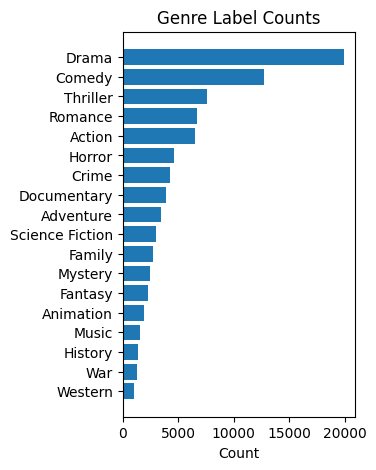

In [14]:
# printing and visualising the genres that will be used:
genre_value_counts = df.genres.explode().value_counts()
print(genre_value_counts)

desc_genre_counts = genre_value_counts.sort_values(ascending=True)

plt.figure(figsize=(3, 5))
plt.barh(y=desc_genre_counts.index, width=desc_genre_counts)
plt.title('Genre Label Counts', size=12)
plt.xlabel('Count')
plt.show()

# We notice a substantial class imbalance, where the most popular genre of 'Drama'
#   has almost 20x as many observations as the least popular genre of 'Western'

In [15]:
# genre correlation matrix 
correl_mat = pd.DataFrame(y).corr().rename(index=dict(enumerate(y_label_encoder.classes_)),
                                           columns=dict(enumerate(y_label_encoder.classes_)))
correl_mat

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
Action,1.000000,0.282590,0.010344,-0.093095,0.151636,-0.128648,-0.104085,-0.038662,0.040877,0.012486,-0.050060,-0.072068,-0.037804,-0.107529,0.151763,0.201252,0.047441,0.086668
Adventure,0.282590,1.000000,0.136000,-0.041084,-0.032330,-0.081585,-0.104543,0.195363,0.187813,0.026060,-0.063805,-0.042396,-0.029054,-0.055726,0.120188,-0.015267,0.019586,0.031874
Animation,0.010344,0.136000,1.000000,-0.006999,-0.062922,-0.058332,-0.157988,0.336256,0.147638,-0.031085,-0.055253,-0.002906,-0.030296,-0.072592,0.067129,-0.086239,-0.028494,-0.029375
Comedy,-0.093095,-0.041084,-0.006999,1.000000,-0.072089,-0.181662,-0.198910,0.073862,0.008274,-0.098819,-0.126620,0.022989,-0.098116,0.151395,-0.071916,-0.222133,-0.083769,-0.053739
Crime,0.151636,-0.032330,-0.062922,-0.072089,1.000000,-0.092364,0.076889,-0.076312,-0.067877,-0.035114,-0.056307,-0.050178,0.150973,-0.075965,-0.069494,0.254934,-0.053250,-0.034836
Documentary,-0.128648,-0.081585,-0.058332,-0.181662,-0.092364,1.000000,-0.267393,-0.066931,-0.073359,0.025551,-0.104718,0.082148,-0.073846,-0.131658,-0.082132,-0.143369,-0.019570,-0.048313
Drama,-0.104085,-0.104543,-0.157988,-0.198910,0.076889,-0.267393,1.000000,-0.090599,-0.084715,0.109463,-0.209076,-0.031898,0.001928,0.168376,-0.150773,-0.021540,0.098158,-0.066440
Family,-0.038662,0.195363,0.336256,0.073862,-0.076312,-0.066931,-0.090599,1.000000,0.192346,-0.037979,-0.085722,0.018124,-0.045088,-0.041899,0.011138,-0.112627,-0.041465,-0.027893
Fantasy,0.040877,0.187813,0.147638,0.008274,-0.067877,-0.073359,-0.084715,0.192346,1.000000,-0.037557,0.038396,-0.005497,-0.000020,-0.010531,0.143250,-0.049055,-0.033220,-0.031864
History,0.012486,0.026060,-0.031085,-0.098819,-0.035114,0.025551,0.109463,-0.037979,-0.037557,1.000000,-0.057893,-0.016681,-0.034278,-0.011988,-0.049035,-0.055054,0.228779,0.004552


In [16]:
# printing each genre and it's most 3 highly correlated co-genres.
for genre in correl_mat:
    print(genre, correl_mat[genre].sort_values(ascending=False)[1:4], '\n', sep='\n')

Action
Adventure          0.282590
Thriller           0.201252
Science Fiction    0.151763
Name: Action, dtype: float64


Adventure
Action     0.282590
Family     0.195363
Fantasy    0.187813
Name: Adventure, dtype: float64


Animation
Family       0.336256
Fantasy      0.147638
Adventure    0.136000
Name: Animation, dtype: float64


Comedy
Romance    0.151395
Family     0.073862
Music      0.022989
Name: Comedy, dtype: float64


Crime
Thriller    0.254934
Action      0.151636
Mystery     0.150973
Name: Crime, dtype: float64


Documentary
Music      0.082148
History    0.025551
War       -0.019570
Name: Documentary, dtype: float64


Drama
Romance    0.168376
History    0.109463
War        0.098158
Name: Drama, dtype: float64


Family
Animation    0.336256
Adventure    0.195363
Fantasy      0.192346
Name: Family, dtype: float64


Fantasy
Family       0.192346
Adventure    0.187813
Animation    0.147638
Name: Fantasy, dtype: float64


History
War          0.228779
Drama        0.109463
A

In [17]:
n_classes = y[0].shape[0]

### 2) Model Design and Training

#### Specifying Model Components 

The first class is used to perform input embedding with positional encoding and the second contains the design for the encoder block of the Transformer.

In [18]:
class InputEmbedding(tf.keras.layers.Layer):
    def __init__(self, input_dim, sequence_length, d_model):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=input_dim, 
                                                   output_dim=d_model,
                                                   mask_zero=True)
        self.pos_encodings = self.generate_positional_encodings(sequence_length=sequence_length,
                                                          d_model=d_model)
        
    def generate_positional_encodings(self, sequence_length, d_model):
        max_wavelength = 10000.
        pos = np.arange(sequence_length)
        inx = np.arange(d_model)
        I, P = np.meshgrid(inx, pos)
        pe_even = np.sin(P / max_wavelength**(I/d_model))
        pe_odd = np.cos(P / max_wavelength**(I/d_model))
        pe = np.zeros((sequence_length, d_model))
        pe[:, ::2] = pe_even[:, ::2]
        pe[:, 1::2] = pe_odd[:, ::2]
        return tf.constant(pe, dtype=tf.float32)

    def compute_mask(self, inputs, mask=None):
        return self.embedding.compute_mask(inputs)
        
    def call(self, inputs):
        n = tf.shape(inputs)[-1]
        pos_encodings = self.pos_encodings[:n, :]
        h = self.embedding(inputs)
        return h + pos_encodings

In [19]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, ff_hidden_units, dropout_rate):
        super().__init__()
        self.supports_masking = True
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_hidden_units, 
                                  activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layer_norms = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
        ]
        self.dropout = [
            tf.keras.layers.Dropout(rate=dropout_rate),
            tf.keras.layers.Dropout(rate=dropout_rate)
        ]


    def get_attention_mask(self, mask=None):
        if mask is None:
            return None
        mask1 = mask[:, :, None]
        mask2 = mask[:, None, :]
        return mask1 & mask2


    def call(self, inputs, mask=None, training=None):
        mask = self.get_attention_mask(mask)
        attention_output = self.multi_head_attention(inputs, inputs, 
                                                     attention_mask=mask)
        attention_output = self.layer_norms[0](inputs + attention_output)
        attention_output = self.dropout[0](attention_output, training=training)
        
        feed_forward_output = self.feed_forward(attention_output)
        feed_forward_output = self.dropout[1](feed_forward_output, training=training)
        
        out = self.layer_norms[1](attention_output + feed_forward_output)
        return out

#### Learning Rate Schedules

We will use a simple step function to control the learning rate. This step function depends on three parameters.

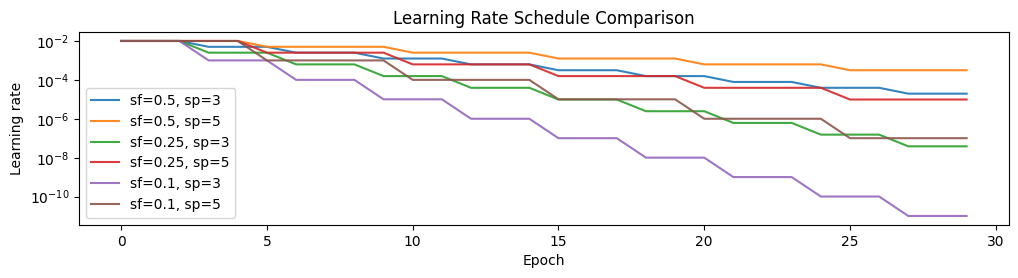

In [20]:
# plotting the learning rate schedule function for various hyperparameter values.
def lr_schedule_function(epoch, initial_lr, scale_factor, lr_scale_patience):
    return initial_lr * scale_factor ** (epoch // lr_scale_patience)

initial_lr = 0.01
example_lr_scale_factors = [0.5, 0.25, 0.1]
example_lr_scale_patiences = [3, 5]

plt.figure(figsize=(12,2.5))

# Plot learning rate schedules for each lr_scale_factor and lr_scale_patience
for lr_scale_factor in example_lr_scale_factors:
    for lr_scale_patience in example_lr_scale_patiences:
        lr_rates = [lr_schedule_function(epoch, initial_lr, lr_scale_factor, lr_scale_patience) for epoch in range(30)]
        plt.plot(lr_rates, label=f"sf={lr_scale_factor}, sp={lr_scale_patience}", alpha=0.9)

# Add axis labels and legend
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning Rate Schedule Comparison')
plt.yscale('log')
plt.legend()
plt.show()

#### Designing Experiment Pipeline 
This class allows us to more conveniently experiment with a model design for a given set of hyperparameters:
1. The class repeats the steps in previous sections by rebuilding and preprocessing the data for each new experiment.
2. Then the Transformer is fit to the processed data and trained for up to 30 epochs.

In [21]:
from dataclasses import dataclass
from typing import Union

@dataclass
class ModelTuningExperiment:
    sequence_length: int
    max_tokens: int 
    batch_size: int
    num_encoder_blocks: int
    num_heads: int
    ff_hidden_units: int
    dropout_rate: float
    d_model: int
    ####
    initial_lr: float = 0.001
    lr_scale_factor: float = 1.0
    lr_scale_patience: int = 100
    classification_threshold: float = 0.5
    ####
    optimizer: Union[str, tf.keras.optimizers.Optimizer] = 'adam' # e.g. 'adam' or 'rmsprop' or a optimizer object
    fixed_seed: int = 0
    ####
    X_test = None #for later test eval
    y_test = None #for later test eval
    n_classes: int = None
    vectorizer: tf.keras.layers.TextVectorization = None
    train_data: tf.data.Dataset = None
    valid_data: tf.data.Dataset = None
    test_data: tf.data.Dataset = None 
    model: tf.keras.Sequential = None 
    history: tf.keras.callbacks.History = None
    ####
    best_val_acc: float = None

        
    def build_raw_datasets(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=.3, 
                                                            random_state=2023)
        X_test, X_val, y_test, y_val = train_test_split(X_test, 
                                                        y_test, 
                                                        test_size=.5, 
                                                        random_state=2023)
        self.X_test = X_test
        self.y_test = y_test
        self.n_classes = y[0].shape[0]
        self.train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        self.valid_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        self.test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        return self
        

    def create_and_adapt_vectorizer(self):
        vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=self.max_tokens,
            pad_to_max_tokens=True
        )
        vectorizer.adapt(self.train_data.map(lambda text, label: text))
        self.vectorizer = vectorizer
        return self

    
    def truncate_input_sequence(self, tokens, labels):
        return tokens[:self.sequence_length], labels
    
    def vectorise_text_inputs(self, text, labels):
        return self.vectorizer(text), labels

    def filter_empty_descriptions(self, tokens, labels):
        return tf.math.greater(tf.size(tokens), 0)

    def filter_empty_labels(self, overview, labels):
        return tf.math.greater(tf.reduce_sum(labels), 0)

    def process_datasets(self):
        '''
        Preprocesses the training, validation and test datasets.
        Applies the provided vectorizer.
        '''
        self.train_data = self.train_data.map(self.vectorise_text_inputs)\
            .filter(self.filter_empty_descriptions)\
            .filter(self.filter_empty_labels)\
            .map(self.truncate_input_sequence)\
            .shuffle(buffer_size=1000)\
            .padded_batch(self.batch_size, 
                          padded_shapes=([self.sequence_length], [self.n_classes]))\
            .prefetch(tf.data.AUTOTUNE)
        
        self.valid_data = self.valid_data.map(self.vectorise_text_inputs)\
            .filter(self.filter_empty_descriptions)\
            .filter(self.filter_empty_labels)\
            .map(self.truncate_input_sequence)\
            .padded_batch(self.batch_size, 
                          padded_shapes=([self.sequence_length], [self.n_classes]))\
            .prefetch(tf.data.AUTOTUNE)
        
        self.test_data = self.test_data.map(self.vectorise_text_inputs)\
            .filter(self.filter_empty_descriptions)\
            .filter(self.filter_empty_labels)\
            .map(self.truncate_input_sequence)\
            .padded_batch(self.batch_size,
                          padded_shapes=([self.sequence_length], [self.n_classes]))\
            .prefetch(tf.data.AUTOTUNE)
        
        return self


    #using sequential API
    def build_model(self):
        tf.random.set_seed(self.fixed_seed) 

        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(None,), dtype=tf.int64),
            
            InputEmbedding(input_dim=self.max_tokens,
                           sequence_length=self.sequence_length,
                           d_model=self.d_model),
            
            tf.keras.Sequential(name='StackedEncoderBlocks', 
                layers = [
                    EncoderBlock(num_heads=self.num_heads, 
                                 d_model=self.d_model, 
                                 ff_hidden_units=self.ff_hidden_units,
                                 dropout_rate=self.dropout_rate)
                    for _ in range(self.num_encoder_blocks)
                ]
            ),
            
            tf.keras.layers.GlobalAveragePooling1D(),
            
            tf.keras.Sequential(name='ff_network', layers=[
                tf.keras.layers.Dense(self.ff_hidden_units, activation='relu'),
                tf.keras.layers.Dense(n_classes, activation='sigmoid')
            ])

        ])
        self.model.build(input_shape=(None, self.sequence_length, 1))
        self.model.compile(optimizer=self.optimizer,
                           loss='binary_crossentropy',
                           metrics=[tf.keras.metrics.BinaryAccuracy(threshold=self.classification_threshold, 
                                                                    name='accuracy')])
        return self

    
    def lr_schedule(self, epoch):
        return self.initial_lr * self.lr_scale_factor ** (epoch // self.lr_scale_patience)
    

    def train_model(self):
        self.history = self.model.fit(x=self.train_data,
                                      epochs=50,
                                      validation_data=self.valid_data,
                                      callbacks=[tf.keras.callbacks.LearningRateScheduler(self.lr_schedule),
                                                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                                  patience=3,
                                                                                  restore_best_weights=True)])
        self.best_val_acc = max(self.history.history['val_accuracy'])
        return self

In [22]:
def run_experiment(**kwargs):
    experiment = ModelTuningExperiment(**kwargs)
    experiment.build_raw_datasets(X,y)\
          .create_and_adapt_vectorizer()\
          .process_datasets()\
          .build_model()\
          .train_model()
    return experiment

#### Preparing the Hyperparameter Space

There are many possible hyperparameters that we can search over for this model. The space of hyperparameter values is far too large to search every possible value. An efficient method may be to use Bayesian optimisation with a Gaussian Process prior, but this may costly to implement without the use of additional libraries. 

As such we will conduct three rounds of experiments:
1. In the first round, we will simply perform a random sampling of candidate hyperparameter values to build up a few observations. Once we have these we may be able to use our own intuition to hand-pick suitable values.
2. Once we have hand-picked some hyperparameter values, we will perform a more explicit and thorough grid search over the hyperparameters `ff_hidden_units` and `d_model`.
3. Finally we will fix the hyperparameters and run experiments for varying RNG seeds. This will allow us to determine a good seed value for our weight initialisations.

#### Step 1) Random Search Tuning

In [87]:
# Search over possible values for prespecified hyperparameter:
hyperparameter_space = {
    'sequence_length': range(20,60),
    'max_tokens': range(1000,21000,1000),
    'batch_size': range(4,256,2),
    'num_encoder_blocks': range(1,5),
    'num_heads': range(2,9),
    'ff_hidden_units': range(16,257,2),
    'dropout_rate': np.linspace(0,.25, 26),
    'd_model': range(16,257,2),
    'initial_lr' : [1e-3],
    'lr_scale_factor' : np.linspace(.05,.15,11),
    'lr_scale_patience': range(3,6),
    'classification_threshold': [0.5],
    'optimizer': ['adam','rmsprop'],
}

In [88]:
# there are O(10^13) combinations, unfortunately we don't have a few hundred million years to try them all.
print('total combinations =', np.product(list(map(lambda x: len(x), list(hyperparameter_space.values())))))

total combinations = 70909853414400


In [24]:
# we can sample 20 combinations randomly to try and select the best model from those
candidate_values = [
    {param: np.random.choice(values) for param, values in hyperparameter_space.items()}
    for _ in range(20)
]


#peek
candidate_values[:2]

[{'sequence_length': 50,
  'max_tokens': 4000,
  'batch_size': 112,
  'num_encoder_blocks': 4,
  'num_heads': 5,
  'ff_hidden_units': 202,
  'dropout_rate': 0.2,
  'd_model': 210,
  'initial_lr': 0.001,
  'lr_scale_factor': 0.13999999999999999,
  'lr_scale_patience': 3,
  'classification_threshold': 0.5,
  'optimizer': 'adam'},
 {'sequence_length': 28,
  'max_tokens': 6000,
  'batch_size': 46,
  'num_encoder_blocks': 1,
  'num_heads': 8,
  'ff_hidden_units': 32,
  'dropout_rate': 0.03,
  'd_model': 236,
  'initial_lr': 0.001,
  'lr_scale_factor': 0.05,
  'lr_scale_patience': 3,
  'classification_threshold': 0.5,
  'optimizer': 'adam'}]

In [26]:
# Running the random search experiments.

experiment_history = []

for i, candidate in enumerate(candidate_values):
    print(f"Starting Experiment {i+1}/{len(candidate_values)}: with params {candidate}")
    experiment = run_experiment(**candidate)
    print(f"Best validation accuracy achieved: {experiment.best_val_acc:.4f}", '\n\n')
    experiment_history.append(experiment)

In [ ]:
sorted_exps = sorted(enumerate(list(map(lambda x: (x.best_val_acc, x.final_val_acc), experiment_history))),
                         key=lambda x: x[1][0],
                         reverse=True)
best_exp = experiment_history[sorted_exps[0][0]]
best_model = best_exp.model

# Based on these experiments we have some intuition about suitable combinations of parameters. 
#  We can now make an informed decision for the next step using grid search.
best_exp

#### Step 2) Grid Search

In [ ]:
hyperparameter_space_2 = {'sequence_length': [150],
                         'max_tokens': [30000], 
                         'batch_size': [32], 
                         'num_encoder_blocks': [1], 
                         'num_heads': [12], 
                         'ff_hidden_units': list(range(32, 257, 32)),
                         'dropout_rate': [0.125], 
                         'd_model': list(range(32, 257, 32)),
                         'optimizer':['rmsprop'],
                        }

from itertools import product 
candidate_values_2 = [dict(zip(hyperparameter_space_2.keys(), values))
                      for values in product(*hyperparameter_space_2.values())]


# peek
candidate_values_2[:2]

In [ ]:
# Running the grid search experiments.

experiment_history_2 = []

for i, candidate in enumerate(candidate_values_2):
    print(f"Starting Experiment {i+1}/{len(candidate_values_2)}: with params {candidate}")
    experiment = run_experiment(**candidate)
    print(f"Best validation accuracy achieved: {experiment.best_val_acc:.4f}", '\n\n')
    experiment_history_2.append(experiment)

In [ ]:
sorted_exps_2 = sorted(enumerate(list(map(lambda x: (x.best_val_acc, x.final_val_acc), experiment_history_2))),
                         key=lambda x: x[1][0],
                         reverse=True)
best_exp_2 = experiment_history_2[sorted_exps_2[0][0]]
best_model_2 = best_exp_2.model

# Based on these experiments we have some idea about suitable values for ff_hidden_units and d_model.
best_exp_2

In [ ]:
exp2_results = pd.DataFrame(np.array(list(map(lambda x: (x.ff_hidden_units, x.d_model, x.final_val_acc, x.best_val_acc), experiment_history_2))),
                            columns=['ff_hidden_units', 'd_model', 'final_val_acc', 'best_val_acc'])

pvt = pd.pivot_table(exp2_results, values='final_val_acc', index=['d_model'], columns=['ff_hidden_units']).iloc[::-1]
pvt.index = pvt.index.astype(int)
pvt.columns = pvt.columns.astype(int)

# plot the heatmap 
plt.imshow(pvt, cmap='Reds', interpolation='nearest')
plt.xticks(range(len(pvt.columns)), pvt.columns)
plt.yticks(range(len(pvt.index)), pvt.index)
plt.xlabel('ff_hidden_units')
plt.ylabel('d_model')
plt.title('Final Validation Set Accuracy')
plt.colorbar()
plt.show()

In [ ]:
sorted_exps_2

#### Step 3) Final Hand--Tuning over Weight Initialisations

The random weight initialisations are important and can dramatically affect model training. For this reason it is sensible to initialise the same architecture many times to find a highly performant initialisation.

In [71]:
from itertools import product 

hyperparameter_space_3 = {'sequence_length': [150],
                         'max_tokens': [30000], 
                         'batch_size': [32], 
                         'num_encoder_blocks': [1], 
                         'num_heads': [12], 
                         'ff_hidden_units': [64],
                         'dropout_rate': [0.15], 
                         'd_model': [128],
                         'fixed_seed': list(range(3)),
                         'optimizer': ['rmsprop'],
                        }

candidate_values_3 = [dict(zip(hyperparameter_space_3.keys(), values))
                      for values in product(*hyperparameter_space_3.values())]

# peek
candidate_values_3[:2]

[{'sequence_length': 150,
  'max_tokens': 30000,
  'batch_size': 32,
  'num_encoder_blocks': 1,
  'num_heads': 12,
  'ff_hidden_units': 64,
  'dropout_rate': 0.15,
  'd_model': 128,
  'fixed_seed': 0,
  'optimizer': 'rmsprop'},
 {'sequence_length': 150,
  'max_tokens': 30000,
  'batch_size': 32,
  'num_encoder_blocks': 1,
  'num_heads': 12,
  'ff_hidden_units': 64,
  'dropout_rate': 0.15,
  'd_model': 128,
  'fixed_seed': 1,
  'optimizer': 'rmsprop'}]

In [72]:
# Running the weight initialisation experiments.

experiment_history_3 = []
    
for i, candidate in enumerate(candidate_values_3):
    print(f"Starting Experiment {i+1}/{len(candidate_values_3)}: with params {candidate}")
    experiment = run_experiment(**candidate)
    print(f"Best validation accuracy achieved: {experiment.best_val_acc:.4f}", '\n\n')
    experiment_history_3.append(experiment)

Starting Experiment 1/3: with params {'sequence_length': 150, 'max_tokens': 30000, 'batch_size': 32, 'num_encoder_blocks': 1, 'num_heads': 12, 'ff_hidden_units': 64, 'dropout_rate': 0.15, 'd_model': 128, 'fixed_seed': 0, 'optimizer': 'rmsprop'}
Epoch 1/50
922/922 [==============================] - 14s 14ms/step - loss: 0.2995 - accuracy: 0.8871 - val_loss: 0.2702 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 2/50
922/922 [==============================] - 13s 13ms/step - loss: 0.2601 - accuracy: 0.8957 - val_loss: 0.2557 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 3/50
922/922 [==============================] - 13s 13ms/step - loss: 0.2392 - accuracy: 0.9036 - val_loss: 0.2442 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 4/50
922/922 [==============================] - 12s 13ms/step - loss: 0.2220 - accuracy: 0.9108 - val_loss: 0.2471 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/50
922/922 [==============================] - 13s 13ms/step - loss: 0.2093 - accuracy: 0.9159 - val_loss: 0.2431 - val_

In [73]:
def get_best_val_acc(item):
    idx, experiment = item
    return experiment.best_val_acc

sorted_exps_3 = sorted(
    enumerate(experiment_history_3),
    key=get_best_val_acc,
    reverse=True
)

best_exp_3 = experiment_history_3[sorted_exps_3[0][0]]
best_model_3 = best_exp_3.model

# Final best model
best_exp_3

ModelTuningExperiment(sequence_length=150, max_tokens=30000, batch_size=32, num_encoder_blocks=1, num_heads=12, ff_hidden_units=64, dropout_rate=0.15, d_model=128, initial_lr=0.001, lr_scale_factor=1.0, lr_scale_patience=100, classification_threshold=0.5, optimizer='rmsprop', fixed_seed=1, n_classes=18, vectorizer=<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f8cf4298ee0>, train_data=<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>, valid_data=<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>, test_data=<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>, model=<keras.engine.sequential.Sequential object at 0x7f8cf4044370>, history=<keras.callbacks.History object a

In [74]:
best_exp_3.model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embedding_14 (InputEm  (None, None, 128)        3840000   
 bedding)                                                        
                                                                 
 StackedEncoderBlocks (Seque  (None, None, 128)        808256    
 ntial)                                                          
                                                                 
 global_average_pooling1d_14  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 ff_network (Sequential)     (None, 18)                9426      
                                                                 
Total params: 4,657,682
Trainable params: 4,657,682
Non-trainable params: 0
___________________________________________

In [75]:
sorted_exps_3

[(1,
  ModelTuningExperiment(sequence_length=150, max_tokens=30000, batch_size=32, num_encoder_blocks=1, num_heads=12, ff_hidden_units=64, dropout_rate=0.15, d_model=128, initial_lr=0.001, lr_scale_factor=1.0, lr_scale_patience=100, classification_threshold=0.5, optimizer='rmsprop', fixed_seed=1, n_classes=18, vectorizer=<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f8cf4298ee0>, train_data=<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>, valid_data=<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>, test_data=<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150), dtype=tf.int64, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>, model=<keras.engine.sequential.Sequential object at 0x7f8cf4044370>, history=<keras.callbacks.History o

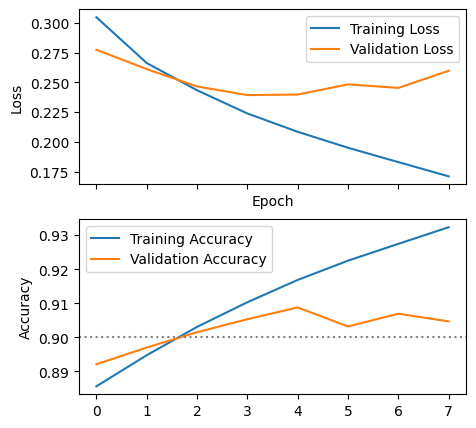

In [76]:
# Plotting the training metrics of the best model
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

axs[0].plot(best_exp_3.history.history['loss'], label='Training Loss')
axs[0].plot(best_exp_3.history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(best_exp_3.history.history['accuracy'], label='Training Accuracy')
axs[1].plot(best_exp_3.history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].axhline(y=0.9, color='grey', linestyle=':')

# Adjust the spacing between subplots and show the plot
fig.subplots_adjust(hspace=0.2)
plt.show()

### 3) Testing

#### Test Set Accuracy and Confusion Matrices 

In [77]:
print(f"Test Set Accuracy: {best_exp_3.model.evaluate(best_exp_3.test_data)[1]}")

198/198 [==============================] - 2s 7ms/step - loss: 0.2464 - accuracy: 0.9054
Test Set Accuracy: 0.9054412841796875


In [78]:
# Get the predicted labels for the test data
y_pred = (best_exp_3.model.predict(best_exp_3.test_data) > best_exp_3.classification_threshold).astype(float)

# Get the true labels for the test data
y_true = []
for k, (_, label) in enumerate(best_exp_3.test_data):
    print(k+1, end='\r') # counter
    y_true.append(label.numpy())
y_true = np.concatenate(y_true)

#overall accuracy
print('Final test set accuracy =',np.mean(y_true == y_pred))
# matches the final result above.

198/198 [==============================] - 2s 6ms/step
Final test set accuracy = 0.9054412798874825


In [79]:
def compute_confusion_matrices(truth: np.ndarray, preds: np.ndarray):
    true_pos = np.logical_and((y_true==1),(y_pred==1)).sum(axis=0)
    true_neg = np.logical_and((y_true==0),(y_pred==0)).sum(axis=0)
    false_pos = np.logical_and((y_true==0),(y_pred==1)).sum(axis=0)
    false_neg = np.logical_and((y_true==1),(y_pred==0)).sum(axis=0)
    
    cm = {}
    for col,genre in enumerate(y_label_encoder.classes_):
        cm[genre] = np.array([[true_pos[col],false_pos[col]],[false_neg[col],true_neg[col]]]).astype(int)
    return(cm)

In [80]:
# Create the confusion matrix for each label
class_names = list(y_label_encoder.classes_)
cm = compute_confusion_matrices(y_true, y_pred)

# normalised_cm = {k: v/y_pred.shape[0] for k,v in cm.items()}

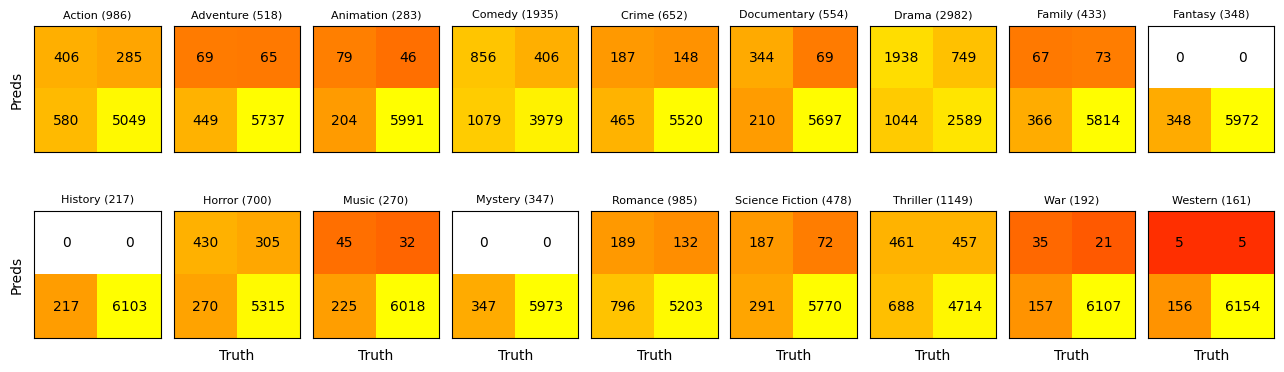

In [81]:
# Plotting the confusion matrices for each label as a 2x10 grid.
num_rows = 2
num_cols = int(n_classes/2)

# Create a new figure and set its size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 6), sharey=True, sharex=True)
plt.subplots_adjust(wspace=.1, hspace= -.33)

axs = axs.ravel()
n_obs = y_true.sum(axis=0).astype(int) # number of each label observed

# Loop through each genre and plot its confusion matrix in a separate subplot
for i, (genre, cmatrix) in enumerate(cm.items()):
    ax = axs[i]
    im = ax.imshow(cmatrix, interpolation='nearest', vmin=1, vmax=y_pred.shape[0], cmap='autumn', norm='log')
    ax.set_title(f"{genre} ({n_obs[i]})", size=8)
    
#     fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04, )
    
    if i > 9:
        ax.set_xlabel('Truth')
    if i%num_cols==0:
        ax.set_ylabel('Preds')

    ax.set_xticks([])
    ax.set_yticks([])
            
    # Add text labels for each cell in the confusion matrix
    for j in range(2):
        for k in range(2):
            text = ax.text(k, j, format(cmatrix[j][k], '.0f'),
                           ha="center", va="center", color="black" )

plt.show()

In [82]:
# precision, recall and F1 scores.

prec_rec_f_scores = np.zeros((n_classes,3))

# Precision and Recall Metrics
for j, (genre,cmatrix) in enumerate(cm.items()):
    genre_tp = cmatrix[0,0]
    genre_fp = cmatrix[0,1]
    genre_fn = cmatrix[1,0]
    genre_tn = cmatrix[1,1]
    genre_precision = genre_tp / (genre_tp+genre_fp)
    genre_recall = genre_tp / (genre_tp+genre_fn)
    genre_f1 = genre_tp/(genre_tp+0.5*(genre_fp+genre_fn))

    prec_rec_f_scores[j,0] = genre_precision
    prec_rec_f_scores[j,1] = genre_recall
    prec_rec_f_scores[j,2] = genre_f1

prec_rec_f_scores = pd.DataFrame(prec_rec_f_scores, 
                                 columns=['Precision','Recall','F1_Score'],
                                 index=cm.keys())

prec_rec_f_scores = prec_rec_f_scores.fillna(0)
prec_rec_f_scores

,Precision,Recall,F1_Score
Action,0.587554,0.411765,0.484198
Adventure,0.514925,0.133205,0.211656
Animation,0.632000,0.279152,0.387255
Comedy,0.678288,0.442377,0.535502
Crime,0.558209,0.286810,0.378926
Documentary,0.832930,0.620939,0.711479
Drama,0.721250,0.649899,0.683718
Family,0.478571,0.154734,0.233857
Fantasy,0.000000,0.000000,0.000000
History,0.000000,0.000000,0.000000


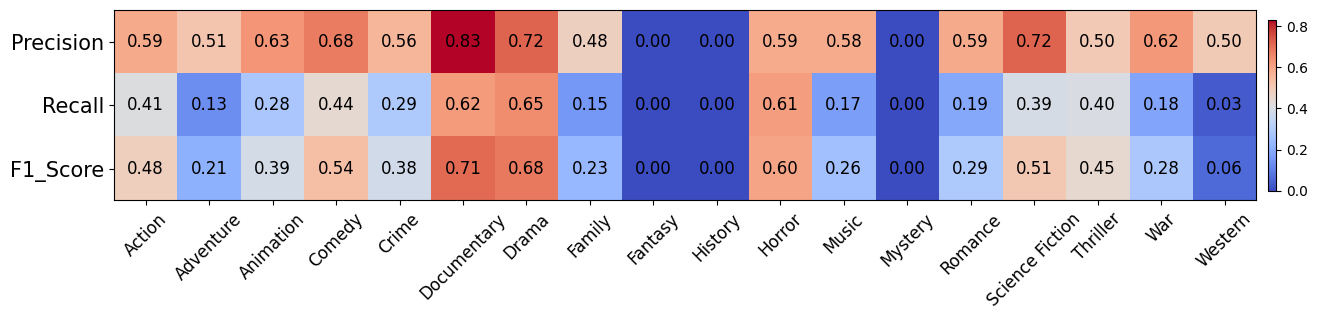

In [83]:
# plotting precision, recall, f1

plt.figure(figsize=(15,3))
plt.imshow(prec_rec_f_scores.T, vmin=0, vmax=prec_rec_f_scores.max().max(), cmap='coolwarm')
plt.colorbar(fraction=.00735, pad=0.01)
plt.xticks(range(len(prec_rec_f_scores.index)), prec_rec_f_scores.index, rotation=45, size=12)
plt.yticks(range(3), prec_rec_f_scores.columns, size=15)

# Add text labels to the heatmap
for i in range(len(prec_rec_f_scores.columns)):
    for j in range(len(prec_rec_f_scores.index)):
        text = "{:.2f}".format(prec_rec_f_scores.iloc[j, i])
        plt.text(j, i, text, ha="center", va="center", color="black", fontsize=12)

plt.show()

#### Testing the Model with Input Strings

In [84]:
# Test Predictions on Fabricated Examples. Test your own by adding a string to the list!

descriptions = [
               "A team of scientists unlock the secrets of teleportation and unleash an infinite universe of possibilities. Now they must face an unprecedented threat in a race against time to save humanity from catastrophe.",
               "A mute orphan overcomes devastating adversity and learns to speak again in this tragic coming-of-age story.",
               "Experience the brutal intensity of D-Day like never before, as recolored footage offers a unique perspective of the heroic soldiers storming the beaches of Normandy.",
               "The streets erupt in a symphony of chaos as an FBI agent, framed for a murder she didn't commit, fights tooth and nail against a corrupt system to clear her name and take down those who betrayed her.",
               "Get ready for a night of non-stop chuckles as three bumbling clowns unwittingly find themselves center stage in a circus act, causing chaos to ensue at every turn!",
               "Embark on a fascinating journey into the hidden world of nocturnal mammals, as this captivating nature programme delves deep into their unique life cycle, behaviors, and survival strategies under the veil of darkness.",
               "Join a mischievous group of kids on an enchanted quest through a mystical realm, as they rally together to thwart the evil wizards and rescue the elf kingdom.",
               "Amid the ruins of a once-thriving city, a lone survivor must navigate a harrowing, post-apocalyptic wasteland plagued by a deadly virus and the worst of human nature, in a desperate struggle to survive.",
               "A robot assassin from a dystopian future is sent back in time to kill the leader of the human resistance.",
               ]

def get_genre_predictions(experiment, descriptions):
    for description in descriptions:
        preds = np.array(experiment.model(experiment.vectorizer([description])).numpy()[0])
        pred_idx = np.where(preds>experiment.classification_threshold)[0]
        labels = list(zip(y_label_encoder.classes_[pred_idx], preds[pred_idx]))
        if not labels: # if none over threshold, then just get the single highest prob label.
            labels = [(y_label_encoder.classes_[np.argmax(preds)], preds[np.argmax(preds)])]

        print('\n',f'description={description}', '\n\n', 'prediction=',sorted(labels, key=lambda x: x[1], reverse=True), '\n')

get_genre_predictions(experiment=best_exp_3, descriptions=descriptions)


 description=A team of scientists unlock the secrets of teleportation and unleash an infinite universe of possibilities. Now they must face an unprecedented threat in a race against time to save humanity from catastrophe. 

 prediction= [('Science Fiction', 0.8753725), ('Action', 0.5229177)] 


 description=A mute orphan overcomes devastating adversity and learns to speak again in this tragic coming-of-age story. 

 prediction= [('Drama', 0.9552138)] 


 description=Experience the brutal intensity of D-Day like never before, as recolored footage offers a unique perspective of the heroic soldiers storming the beaches of Normandy. 

 prediction= [('Documentary', 0.86815417)] 


 description=The streets erupt in a symphony of chaos as an FBI agent, framed for a murder she didn't commit, fights tooth and nail against a corrupt system to clear her name and take down those who betrayed her. 

 prediction= [('Action', 0.79605836), ('Thriller', 0.70161915)] 


 description=Get ready for a nig

In [86]:
# Peek at some of the real test data from the Kaggle dataset. 

for j in range(10):
    get_genre_predictions(experiment = best_exp_3, descriptions = [best_exp_3.X_test.iloc[j]])
    print('true_label=',y_label_encoder.classes_[np.where(best_exp_3.y_test[j])[0]],'\n')


 description=A new woman comes between a widower and his adult son. 

 prediction= [('Drama', 0.96031016)] 

true_label= ['Drama' 'Romance'] 


 description=The boys get mixed up with a race horse &amp; crooked gamblers 

 prediction= [('Comedy', 0.6333505)] 

true_label= ['Comedy'] 


 description=The movie tells the story of the successful uprising of the indigenous peoples of Bougainville Island against the Papua New Guinea army and the mining plans of the mining corporation Rio Tinto Zinc (RTZ) to exploit their natural resources. The documentary reveals how the Bougainville Revolutionary Army (BRA) managed to overcome the marine blockade strategy used by the Papuan army by using coconut oil as fuel for their vehicles. 

 prediction= [('Documentary', 0.9724407)] 

true_label= ['Documentary'] 


 description=A Short Film About John Bolton is a darkly hip and hilarious film explores the question that torments artists of every medium: "Where do your ideas come from?"  Renowned artist 